# Gachon corpus: Preprocessing + EDA of second language learners' corpus data

Basic NLP preprocessing steps + feature engineering. Corpus: Gachon - http://koreanlearnercorpusblog.blogspot.com/p/corpus.html

In [11]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from spellchecker import SpellChecker
import sys
import seaborn as sns
from sklearn.decomposition import PCA
sys.path.append("../movielingo/")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from movielingo.config import gachon_dir, processed_data_dir
raw_directory = gachon_dir
raw_filename = "Gachon Learner Corpus - Final Version.xlsx"
raw_filepath = raw_directory / raw_filename
processed_directory = processed_data_dir
processed_filename = '01_gachon_processed.csv'# file to be saved after data cleaning
processed_filepath = processed_directory / processed_filename

## 01. Clean data

In [3]:
gachon = pd.read_excel(raw_filepath)

In [4]:
check_if_numeric = lambda x: str(x).isdigit()

In [5]:
gachon["toeic_good"] = gachon['TOEIC Score 토익 점수'].apply(check_if_numeric)
print(gachon[gachon.toeic_good == 0]['TOEIC Score 토익 점수'].unique())

['x' 'X' '×' '270~300']


In [11]:
gachon.at[(gachon['TOEIC Score 토익 점수'] == '270~300'), 'TOEIC Score 토익 점수'] = np.median((270,300))

In [12]:
gachon["toeic_good"] = gachon['TOEIC Score 토익 점수'].apply(check_if_numeric)

In [13]:
print(gachon[gachon.toeic_good == 0]['TOEIC Score 토익 점수'].unique())

['x' 'X' '×' 285.0]


In [14]:
gachon = gachon[gachon.toeic_good == 1].copy()

In [15]:
gachon.rename(columns={'TOEIC Score 토익 점수': "toeic", "Student number:": "student",
                               "Please answer the following question. Write between 100 and 150 words. 다음 질문에 100~150단어 답해주십시오.":
                               "text"}, inplace = True)

In [20]:
gachon_relevant = gachon[['student','text','toeic']]
gachon_relevant.loc[:,'student'] = gachon_relevant.student.astype(str).copy() + '_' + gachon_relevant.toeic.astype(str).copy()

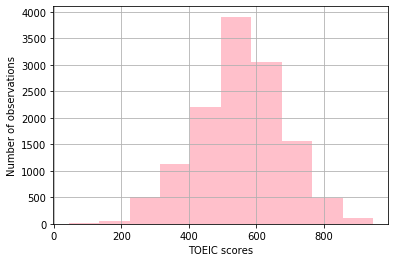

In [21]:
gachon_relevant.toeic.hist(color = 'pink')
plt.xlabel('TOEIC scores')
plt.ylabel('Number of observations');

In [22]:
print('Number of students:', len(gachon_relevant.student.unique()))

Number of students: 1528


#### TOEIC to CEFR conversion:
- 120-254 - A1
- 255-549 - A2
- 550-784 - B1
- 785-944 - B2
- 945-... - C1

https://www.yumpu.com/en/document/read/11409349/correlation-table-toeicr-listening-and-reading-scores

In [23]:
def toeic2cefr(row):
    if row.toeic < 120:
        return None
    elif row.toeic < 255:
        return 'A1'
    elif row.toeic < 550:
        return 'A2'
    elif row.toeic < 785:
        return 'B1'
    elif row.toeic < 945:
        return 'B2'
    elif row.toeic > 944:
        return 'C1'
    else:
        return None

In [26]:
cefr_scores = gachon_relevant.apply(toeic2cefr, axis = 1).copy()
gachon_relevant.loc[:,'cefr'] = cefr_scores.copy()

## 02. Explore language proficiency scores

Reading some texts here to get a better sense of them

In [57]:
text_index = 900
print(gachon_relevant.text.iloc[text_index])
print('toeic:', gachon_relevant.toeic.iloc[text_index])
print('cefr:', gachon_relevant.cefr.iloc[text_index])

My most hate aggressive driving is Cut in my road.
When I beginner level driver, I drive to mart. It was 12:00 pm. It was very bright, not dark. And road is not crowded. No traffic jam.
It was vest day for beginner driver…but when I go back to home, run left side big car had cut in my front.
I push my break, and i almost dead. And I have trauma drive to out.
Cut in is very dengerous driving. It was cause accident. I think, someone have care for other driver, don’t cut in other car’s front.
And you must have cut in, you turn on light and give a sing ‘I’ll have cut in your front. It’s OK?’
toeic: 440
cefr: A2


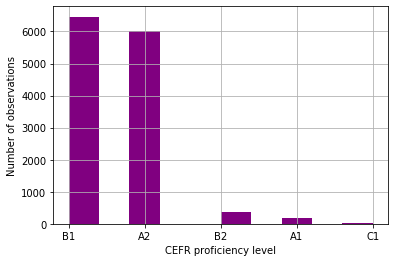

In [27]:
gachon_relevant.cefr.hist(color = 'purple')
plt.xlabel('CEFR proficiency level')
plt.ylabel('Number of observations');

In [28]:
gachon_relevant.to_csv(processed_filepath)

In [6]:
import movielingo.text_utils
import movielingo.single_text_processor
from movielingo.batch_text_processing_multi import create_df_from_texts

In [10]:
df = create_df_from_texts(processed_filepath) # this can take from 12 min to 5 hours depending on your machine

In [ ]:
df.to_csv('../data/processed/02_gachon_features.csv', index = False)

## 03. Explore NLP features

In [4]:
df = pd.read_csv(processed_directory / '02_gachon_features.csv')

In [5]:
df.head()

,text_id,L2_proficiency,n_uniq_lemmas,mean_sent_len,median_sent_len,sd_sent_len,mean_word_len,mean_wf_lemma,mean_wf_token,mean_n_uniq_rare_lemmas,...,vp_t,c_t,cp_t,cp_c,cn_t,cn_c,ct_t,t_s,dc_t,dc_c
0,21011008_780,780,2.033333,13.125000,12.5,3.479853,105.0,-7.317674,-7.437929,0.016393,...,2.875000,2.000000,0.012500,0.006250,1.375000,0.687500,0.062500,10.0,0.100000,0.050000
1,21011008_780,780,2.100000,14.571429,15.0,3.886134,102.0,-7.201932,-7.301136,0.015873,...,2.142857,1.571429,0.014286,0.009091,0.242857,0.154545,0.042857,10.0,0.042857,0.027273
2,21011008_780,780,1.933333,17.200000,15.0,6.584831,86.0,-7.885435,-7.814098,0.017241,...,2.400000,1.800000,0.000000,0.000000,0.760000,0.422222,0.080000,10.0,0.080000,0.044444
3,21011008_780,780,1.900000,15.000000,16.0,4.035556,105.0,-6.950617,-6.997663,0.017544,...,3.285714,2.142857,0.028571,0.013333,0.242857,0.113333,0.085714,10.0,0.100000,0.046667
4,21011008_780,780,1.966667,13.625000,10.5,6.081478,109.0,-7.321971,-7.601701,0.016949,...,2.000000,1.625000,0.000000,0.000000,12.637500,7.776923,0.050000,10.0,0.050000,0.030769


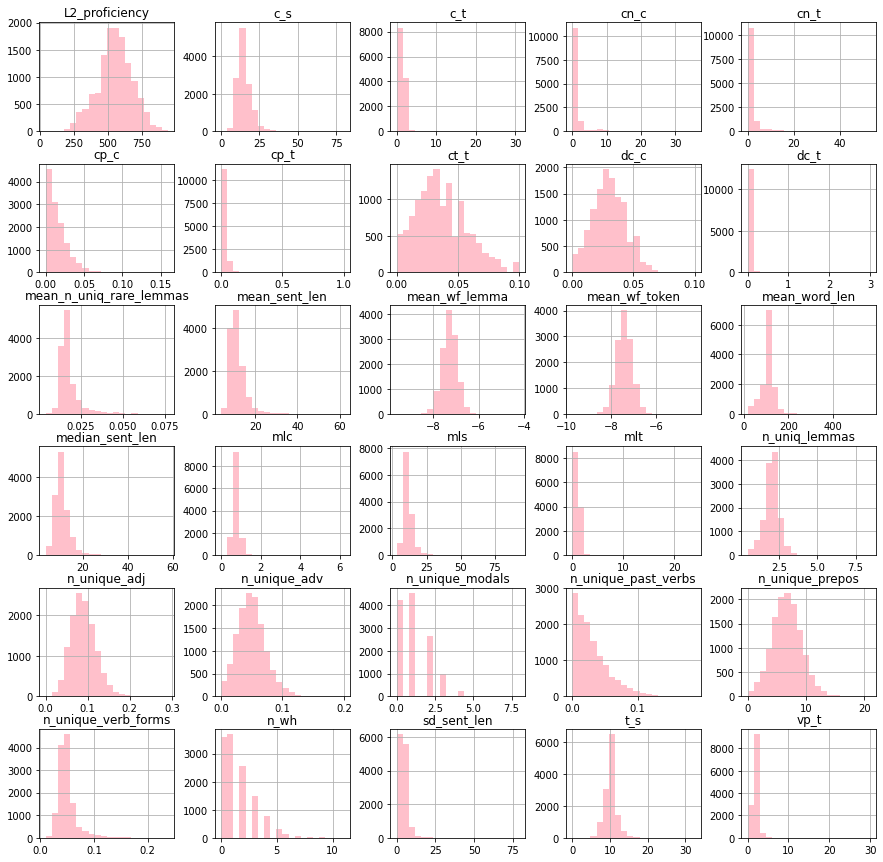

In [7]:
df.hist(figsize = (15,15), bins = 20, color = 'pink');

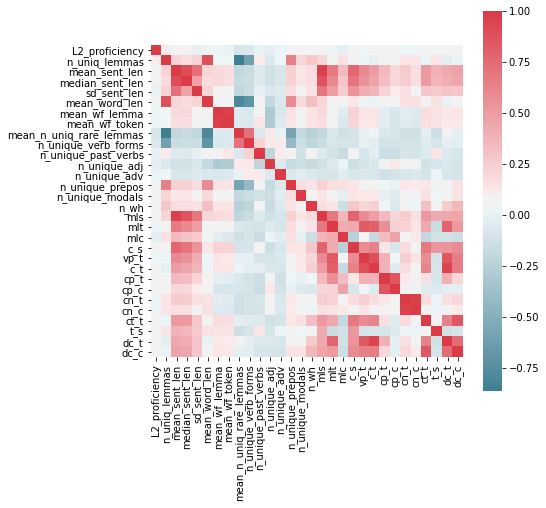

In [8]:
f, ax = plt.subplots(figsize=(7, 7))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

Surprisingly, nothing seems to correlate with second language proficiency. The reason for that could be a low signal-to-noise ratio caused by student entering the texts remotely (potentially using props such as vocabularies and the web). In the text exploration about (around cell 57) one can already see that the language proficiency of a speaker is not entirely intuitive to the reader given the text of the essay alone.

I will continue by reducing the dimensions in the data using PCA and then building a supervised model asking if even with such a low signal-to-noise ratio we could predict language proficiency based on the features selected.

## 04. PCA

How many components would we need?

In [9]:
X = df.drop(['text_id', 'L2_proficiency', 'mls'], axis = 1)

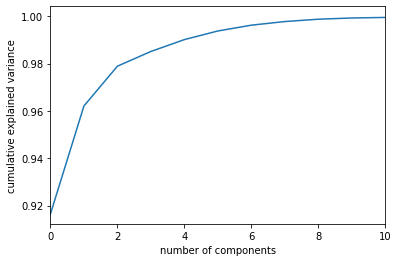

In [12]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim(0,10);

In [13]:
pca6 = PCA(n_components=6)
pca6.fit(X)
projected = pca6.fit_transform(X)
projected.shape

(12657, 6)

In [35]:
l2 = np.expand_dims(df.L2_proficiency, axis = 1)
projected_wL2Prof = np.append(projected, l2, axis=1)
df_proj = pd.DataFrame(data=projected_wL2Prof, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'L2'])

In [39]:
corr_proj = df_proj.corr()
corr_proj.sort_values(by = 'L2')

,PC1,PC2,PC3,PC4,PC5,PC6,L2
PC5,1.119891e-17,-1.021058e-16,2.420858e-17,4.964499e-16,1.000000e+00,-1.181137e-16,-0.074567
PC4,-2.975135e-17,-4.251886e-17,-3.652008e-17,1.000000e+00,4.964499e-16,2.682530e-16,-0.048224
PC6,-1.675462e-17,-8.534861e-18,9.980150e-18,2.682530e-16,-1.181137e-16,1.000000e+00,-0.019790
PC3,5.632135e-18,2.626841e-17,1.000000e+00,-3.652008e-17,2.420858e-17,9.980150e-18,-0.014747
PC2,7.543522e-17,1.000000e+00,2.626841e-17,-4.251886e-17,-1.021058e-16,-8.534861e-18,0.059449
PC1,1.000000e+00,7.543522e-17,5.632135e-18,-2.975135e-17,1.119891e-17,-1.675462e-17,0.092986
L2,9.298580e-02,5.944948e-02,-1.474676e-02,-4.822352e-02,-7.456717e-02,-1.979012e-02,1.000000
